In [1]:
# Import necessary libraries for data manipulation, machine learning, and visualization
import pandas as pd      # Data manipulation and analysis
import numpy as np       # Numerical computing
import requests          # Making HTTP requests to download data
import seaborn as sns    # Advanced data visualization
import matplotlib.pyplot as plt  # Basic data visualization

# Import machine learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Data preprocessing tools
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from sklearn.feature_extraction.text import TfidfVectorizer  # Converting text to numerical features
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score  # Model evaluation metrics
from sklearn.ensemble import RandomForestClassifier  # Machine learning algorithm
from sklearn.utils import resample  # Tool for resampling data

# # Suppress warning messages to keep the output clean
# import warnings
# warnings.filterwarnings('ignore')

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3906
           1       0.97      0.96      0.97      3906

    accuracy                           0.97      7812
   macro avg       0.97      0.97      0.97      7812
weighted avg       0.97      0.97      0.97      7812



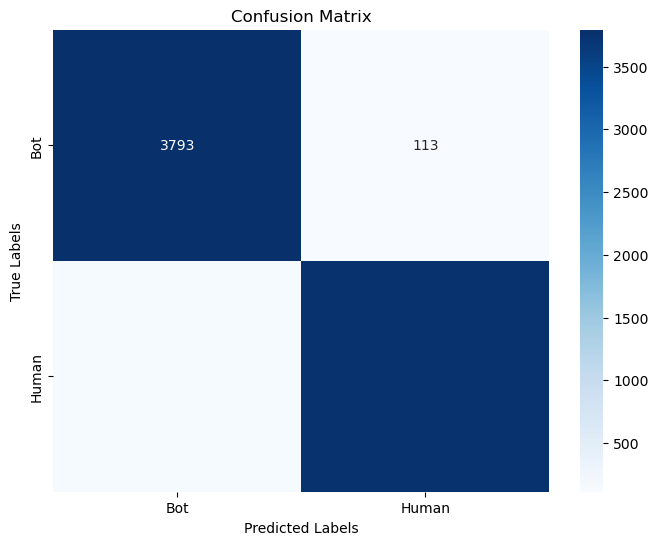

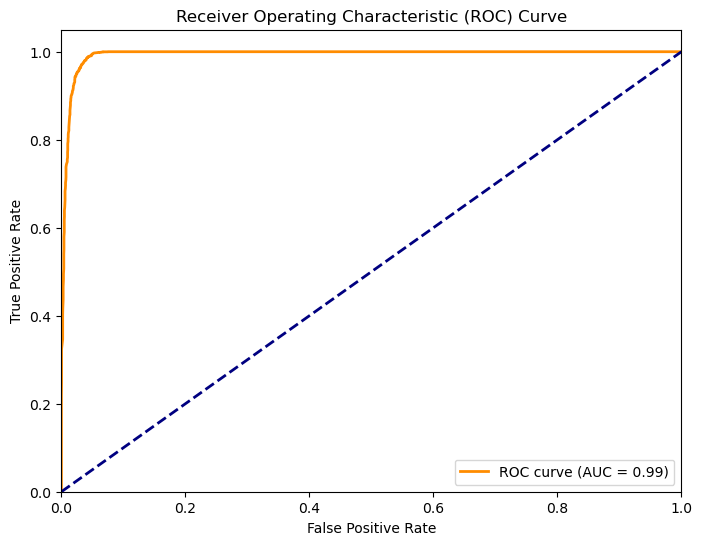

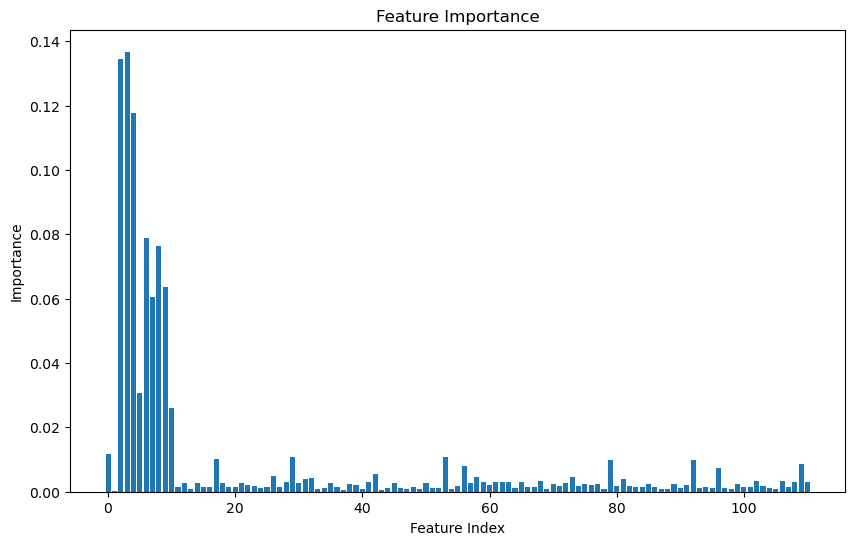

In [22]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Load the dataset
url = "https://huggingface.co/datasets/airt-ml/twitter-human-bots/resolve/main/twitter_human_bots_dataset.csv"
response = requests.get(url)
with open("twitter_human_bots_dataset.csv", "wb") as f:
    f.write(response.content)
df = pd.read_csv("twitter_human_bots_dataset.csv")

# Preprocess the data inline (no separate functions)
df = df.dropna().reset_index(drop=True)

# Encode account_type as numerical
le = LabelEncoder()
df['account_type_encoded'] = le.fit_transform(df['account_type'])

# Convert boolean columns to integers
boolean_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
for col in boolean_cols:
    df[col] = df[col].astype(int)

# Encode language
df['lang_encoded'] = le.fit_transform(df['lang'])

# Remove unnecessary columns
df_model = df.drop(columns=[
    'Unnamed: 0', 'created_at', 'id', 'profile_background_image_url', 
    'profile_image_url', 'screen_name', 'location', 'account_type', 'lang'
])

# Convert text to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_description_tfidf = tfidf_vectorizer.fit_transform(df['description']).toarray()

X_numerical = df_model.drop(columns=['account_type_encoded', 'description'], axis=1)
X_combined = np.hstack((X_numerical.to_numpy(), X_description_tfidf))
y = df_model['account_type_encoded']

# Balance the dataset
df_combined = pd.DataFrame(X_combined)
df_combined['account_type_encoded'] = y

df_majority = df_combined[df_combined['account_type_encoded'] == 1]  # Humans
df_minority = df_combined[df_combined['account_type_encoded'] == 0]  # Bots

df_minority_oversampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_oversampled])

X_balanced = df_balanced.drop('account_type_encoded', axis=1).to_numpy()
y_balanced = df_balanced['account_type_encoded']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# Train a Random Forest model
rf = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=None,
    class_weight=None,
    bootstrap=False,
    random_state=42
)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bot", "Human"], yticklabels=["Bot", "Human"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
feature_importance = rf.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

In [24]:
df_combined

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,account_type_encoded
1,0.0,0.0,536.0,860.0,880.0,0.0,252.0,0.0,0.183,1379.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,1
2,0.0,0.0,3307.0,172.0,594.0,1.0,1001.0,0.0,0.864,1159.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,1
3,0.0,0.0,88.0,753678.0,116.0,1.0,4202.0,1.0,1.339,3138.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,1
4,0.0,0.0,5522.0,291529.0,1581.0,1.0,14535.0,1.0,3.581,4059.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,1
5,0.0,0.0,756.0,6909959.0,40.0,0.0,1223.0,1.0,0.421,2902.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15402,1.0,0.0,168.0,3.0,87.0,0.0,63.0,0.0,0.020,3166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46576,0.0,0
16885,1.0,0.0,4191.0,43.0,150.0,0.0,2178.0,0.0,0.982,2218.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0
2855,1.0,1.0,0.0,8.0,33.0,0.0,2143.0,0.0,0.923,2323.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0
17541,0.0,0.0,32.0,1890.0,42.0,0.0,18690.0,0.0,14.763,1266.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0
